# ABM para Investigação de Dinâmicas Populacionais Urbanas

O objetivo de um ABM é buscar uma transição de fase definida por um comportamento emergente no espaço dos parâmetros do modelo.

O modelo original tinha 2 tipos de agente
- **Povo de Rua** (a) com um parâmetro de threshold que define uma regra de mudança;
- **Domicilios** (b) com um parâmetro de threshold que define uma regra de mudança;

Esses agentes ocupavam uma grade retangular MxN que continha apenas um atributo: a contagem de agentes do tipo (b) em cada célula. Para os agentes (a) a regra threshold forçava uma mudança (aleatória na grade) quando o número de agentes em sua célula do tipo (b) caia abaixo de um certo valor. Já os agentes do tipo (b) tinham uma regra de threshold que forçava uma mudança (aleatória na grade) quando o número de agente em sua célula crescia demais.

Os threshold eram definidos através de variáveis aleatórias, amostrada na criação de cada instância de um agente. O parâmetro deste modelo era justamente a relação entre Densidade de Agentes (tamanho da grade por número de instâncias de agentes), e os parâmetros das distribuições de threshold.

Falta um atributo de VALOR que seja composto por diversos outros atributos da grade;
Falta um agente de Segurança;
Falta atributos de Infraestrutura;

## FUNÇÃO VALOR
Consegue transformar uma célula da grade em valor para cada um dos agentes.

## AGENTE SEGURANÇA (c)
Tem um threshold sobre o valor(a * SA, b * SB) - se a soma deles cai para baixo de um threshold, ela se muda.
### Alteração do valor(a)
Deve dificultar a presença do agente tipo (a) - reduzindo o valor(a) de uma célular.

## FUNÇÃO INFRAESTUTURA
Uma função que atribui a cada célula um valor de infraestrutura.
### Alocação de Infraestrutura
Inicialmente faremos uma alocação usando ruído de Perlin. A cada etapa, o valor de N regiões (N sendo um parametro do modelo, chamado Orçamento) é incrementado. A função de ranqueamento tem que penalizar (temos?) celulas de alta infrasestrutura existente e beneficiar celulas de alta população.
#### SP Capital
A alocação de recursos é limitada pelos limites geopolíticos da cidade.
### Deterioração da Infraestrutura
A cada etapa da simulação, cada célula tem uma chance de perder N pontos de infraestrutura.

## AGENTE IGREJA (d)
Tem um threshold sobre o valor(a * IA, b * IB) - se a soma deles cai para baixo de um threshold, ela se muda.
### Alteração do valor(a)
A Igreja busca construir um equilibrio da população do agente (a) - ela altera o valor da celula para agentes (a) nos dois sentidos: se o valor está abaixo de um threshold, ela o aumenta, se ele esta acima, ela o reduz.

# Framework de Desenvolvimento

- Começar implantando infraestrutura.
- Adicionar agentes (c) e (d)
 

In [16]:
import random

class Grid:
    '''
    '''
    def __init__(self, x, y):
        '''

            loc_dict Dict: dicionário para conter atributos do modelo e agentes.
            loc_pairs List: lista com pares de coordenadas (usada para amostragem aleatória)
        '''
        self.x_size = x
        self.y_size = y
        self.loc_pairs = [(i, j) for i in range(x) for j in range(y)]
        self.agent_set = set()
        self.loc_dict = dict()
        for i in range(x):
            for j in range(y):
                self.loc_dict[(i,j)] = dict()
                self.loc_dict[(i,j)]['infrastructure'] = 0
                self.loc_dict[(i,j)]['agent_present'] = set()

    def return_coord_pair(self):
        '''
        Retorna um par de coordenadas aleatoriamente.
        '''
        return random.choice(self.loc_pairs)

    def add_agent_position(self, pos_tuple, agent):
        '''
        Adiciona um agente na posição x, y = pos_tuple.
        '''
        self.loc_dict[(pos_tuple[0], pos_tuple[1])]['agent_present'].add(agent)

    def change_agent_position(self, agent, new_pos):
        '''
        '''
        self.loc_dict[(agent.x_pos, agent.y_pos)]['agent_present'].remove(agent)
        self.loc_dict[(new_pos[0], new_pos[1])]['agent_present'].add(agent)

class Agent:
    '''
    Classe representando um Agente genérico

    '''
    def __init__(self, grid):
        '''
        Parameters:
            grid Grid: objeto Grid onde o agente residirá
        Attributes:
            pos Tuple: tuple com posição x, y do agente no Grid
        '''
        self.x_pos, self.y_pos = grid.return_coord_pair()
        self.grid = grid
        self.grid.add_agent_position((self.x_pos, self.y_pos), self)

    def move(self):
        new_pos = self.grid.return_coord_pair()
        self.grid.change_agent_position(self, new_pos)
        self.x_pos, self.y_pos = new_pos

class AgentA(Agent):
    '''
    Classe representando o Povo de Rua
    '''
    def __init__(self, grid, thresh_dict):
        super().__init__(grid)
        self.thresh_dict = thresh_dict

    def regra_movimento(self):
        '''
        Avalia atributos da Grid para determinar se agente se muda ou não
        '''
        condicao = True
        for threshold in self.thresh_dict.keys():
            if self.thresh_dict[threshold] < self.grid.loc_dict[(self.x_pos, self.y_pos)][threshold]:
                condicao = True
                break
        if condicao:
            self.move()

In [24]:
grade_teste = Grid(2, 2)
for i in range(100):
    Agent(grade_teste)

In [31]:
len(grade_teste.loc_dict[1,1]['agent_present'])

30

In [11]:
x = 2
y = 2
loc_dict = dict()

In [12]:
for i in range(x):
    for j in range(y):
        loc_dict[(i,j)] = dict()
        loc_dict[(i,j)]['infra'] = 0
        loc_dict[(i,j)]['agent_set'] = set()

In [15]:
loc_dict

{(0, 0): {'infra': 0, 'agent_set': set()},
 (0, 1): {'infra': 0, 'agent_set': set()},
 (1, 0): {'infra': 0, 'agent_set': set()},
 (1, 1): {'infra': 0, 'agent_set': set()}}

## Usando MESA

In [30]:
!pip install perlin-noise

In [32]:
import mesa, random
import numpy as np
from scipy.stats import pareto, norm
from perlin_noise import PerlinNoise

In [138]:
def perlin_grid(height, width):
    noise1 = PerlinNoise(octaves=3)
    noise2 = PerlinNoise(octaves=6)
    noise3 = PerlinNoise(octaves=12)
    noise4 = PerlinNoise(octaves=24)

    xpix, ypix = height, width
    pic = []
    for i in range(xpix):
        row = []
        for j in range(ypix):
            noise_val = noise1([i/xpix, j/ypix])
            noise_val += 0.5 * noise2([i/xpix, j/ypix])
            noise_val += 0.25 * noise3([i/xpix, j/ypix])
            noise_val += 0.125 * noise4([i/xpix, j/ypix])

            row.append(noise_val)
        pic.append(row)
    pic_array = np.array(pic)
    pic_array = pic_array - np.min(pic_array)
    pic_array = pic_array/np.max(pic_array)
    return pic_array

In [248]:
class PopRua(mesa.Agent):
    def __init__(self, unique_id, model, parametros_agente):
        '''
        parametros_agente: tuple com os parametros de cada tipo de agente diferente
        '''
        super().__init__(unique_id, model)
        self.threshold = norm.rvs(parametros_agente[0], parametros_agente[1])

    def value_function(self):
        value = self.model.location.param_dict[self.pos[0]][self.pos[1]]['value']
        infra = self.model.location.param_dict[self.pos[0]][self.pos[1]]['infrastructure']
        return value + PESO_INFRA * infra

    def move(self):
        new_position_x = random.randint(0, self.model.grid.height - 1)
        new_position_y = random.randint(0, self.model.grid.width - 1)
        new_position = (new_position_x, new_position_y)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        if self.value_function() < self.threshold:
            self.move()

class PopCasa(mesa.Agent):
    def __init__(self, unique_id, model, parametros_agente):
        '''
        parametros_agente: tuple com os parametros de cada tipo de agente diferente
        '''
        super().__init__(unique_id, model)
        self.threshold = pareto.rvs(b=parametros_agente[0]) * parametros_agente[0]

    def value_function(self):
        value = self.model.location.param_dict[self.pos[0]][self.pos[1]]['value']
        infra = self.model.location.param_dict[self.pos[0]][self.pos[1]]['infrastructure']
        return value - PESO_INFRA * infra

    def move(self):
        new_position_x = random.randint(0, self.model.grid.height - 1)
        new_position_y = random.randint(0, self.model.grid.width - 1)
        new_position = (new_position_x, new_position_y)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        if self.value_function() > self.threshold:
            self.move()

class Locacao:
    '''
    '''
    def __init__(self, height, width, model):
        param_dict = dict()
        self.model = model
        
        for i in range(height):
            param_dict[i] = dict()
            for j in range(width):
                param_dict[i][j] = dict()
        self.param_dict = param_dict
        self.initialize_infrastructure(height, width)

    def update_value(self):
        '''
        O valor de uma célula da grade é a média do número de pessoas na vizinhança de Moore da celula.
        '''
        for cell in self.model.grid.coord_iter():
            viz = self.model.grid.get_neighborhood(
                (cell[1], cell[2]), moore=True, include_center=True
            )
            pessoas = []
            for cell_v in viz:
                pessoas.extend(self.model.grid.get_cell_list_contents(cell_v))

            casas = [pessoa for pessoa in pessoas if isinstance(pessoa, PopCasa)]
            num_ocup = len(casas) / 9
            self.param_dict[cell[1]][cell[2]]['value'] = num_ocup

    def get_value(self, x, y):
        return self.param_dict[x][y]['value']

    def initialize_infrastructure(self, height, width):
        perlin_noise = perlin_grid(height, width)
        for i in range(height):
            for j in range(width):
                self.param_dict[i][j]['infrastructure'] = perlin_noise[i,j]

    def update_infrastructure(self):
        '''
        Infraestrutura degrada ao longo do tempo.
        '''
        
        top_value = np.max(self.get_value_matrix())
        for cell in self.model.grid.coord_iter():
            infra = self.param_dict[cell[1]][cell[2]]['infrastructure']
            value = self.param_dict[cell[1]][cell[2]]['value']
            if infra > MIN_INFRASTRUCTURE:
                if random.random() < P_DEGRADACAO:
                    self.param_dict[cell[1]][cell[2]]['infrastructure'] *= (1-TX_DEGRADACAO)
                    infra = self.param_dict[cell[1]][cell[2]]['infrastructure']

    def get_infra_matrix(self):
        infra_list = []
        for i in self.param_dict.keys():
            row = []
            for j in self.param_dict[i].keys():
                row.append(self.param_dict[i][j]['infrastructure'])
            infra_list.append(row)
        return np.array(infra_list)

    def get_value_matrix(self):
        value_list = []
        for i in self.param_dict.keys():
            row = []
            for j in self.param_dict[i].keys():
                row.append(self.param_dict[i][j]['value'])
            value_list.append(row)
        return np.array(value_list)

    def update(self):
        self.update_value()
        self.update_infrastructure()

class ModeloUrbano(mesa.Model):
    def __init__(self, dens, height, width, dict_agent):
        self.grid = mesa.space.MultiGrid(height, width, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.num_agents = int(dens * height * width)
        self.dict_agent = dict_agent
        # Create agents
        id_u = 0
        for tipo_agente in dict_agent.keys():
            num_agentes_tipo = self.num_agents * dict_agent[tipo_agente]['prop']
            for i in range(int(num_agentes_tipo)):
                a = tipo_agente(id_u, self, dict_agent[tipo_agente]['param'])
                x = self.random.randrange(self.grid.height)
                y = self.random.randrange(self.grid.width)
                self.grid.place_agent(a, (x, y))
                self.schedule.add(a)
                id_u += 1

        self.location = Locacao(height, width, self)

    def step(self):
        """Advance the model by one step."""
        self.location.update()
        self.schedule.step()

    def return_agent_matrix(self):
        array_dict = dict()
        for tipo_agent in self.dict_agent.keys():
            array_dict[tipo_agent] = np.zeros((self.grid.height, self.grid.width))
        for agents, x, y in self.grid.coord_iter():
            for agent in agents:
                for tipo_agent in self.dict_agent.keys():
                    if isinstance(agent, tipo_agent):
                        array_dict[tipo_agent][x,y] += 1
        return array_dict

In [249]:
# PARAMETROS GLOBAIS
P_DEGRADACAO = 0.01
TX_DEGRADACAO = 0.25
MIN_INFRASTRUCTURE = 0.01

# DE AGENTE CASA
PESO_INFRA = 2

In [250]:
dict_agente = dict()
dict_agente[PopRua] = dict()
dict_agente[PopRua]['prop'] = 0.01
dict_agente[PopRua]['param'] = (6, 4)

dict_agente[PopCasa] = dict()
dict_agente[PopCasa]['prop'] = 0.99
dict_agente[PopCasa]['param'] = (3, 42)

In [251]:
ab = ModeloUrbano(2, 20, 20, dict_agente)

In [252]:
for i in range(500):
    ab.step()

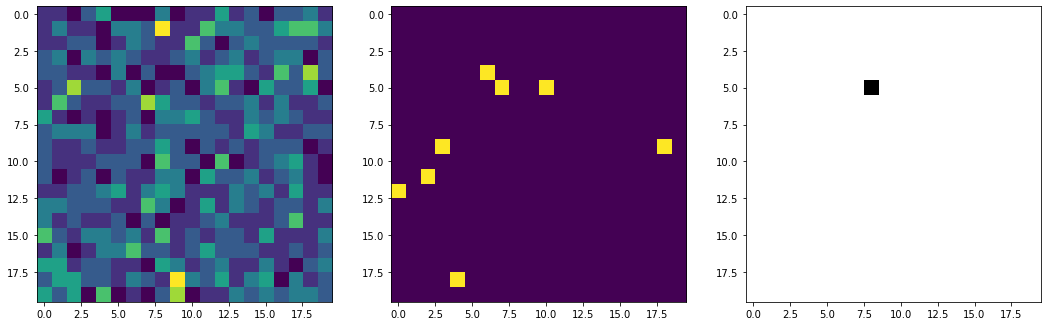

In [253]:
resultado = ab.return_agent_matrix()
infra_matrix = ab.location.get_infra_matrix()
fig, ax = plt.subplots(1,3, figsize = (18, 6))
ax[0].imshow(resultado[PopCasa])
ax[1].imshow(resultado[PopRua])
ax[2].imshow(infra_matrix, cmap = 'gray')

In [254]:
infra_matrix

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.